On voit ce qu'on a dans les CSVs des villes :

On va prendre l'année 2021 en référence

CSV de test : https://files.data.gouv.fr/geo-dvf/latest/csv/2021/full.csv.gz

## Récupération du fichier

In [1]:
from pathlib import Path
DATASET_PATH = Path("./dataset.csv.gz")
DATASET_URL = "https://files.data.gouv.fr/geo-dvf/latest/csv/2021/full.csv.gz"

In [2]:
import requests

def download_file(url: str, dest: Path):
    response = requests.get(url)
    with dest.open("wb") as file:
        file.write(response.content)

In [3]:
download_file(DATASET_URL, DATASET_PATH)

Chargement du fichier

In [4]:
import pandas as pd

# Some types are needed to be read as specific types in order to avoid unwanted conversions
type_by_id = {
    "adresse_numero": int,
    "code_postal": str,
    "code_type_local": int,
    "valeur_fonciere": int,
    "surface_terrain": int,
    "nombre_pieces_principales": int
}

df: pd.DataFrame = pd.read_csv(DATASET_PATH.as_posix(), low_memory=False)
print("columns", df.columns)
df.head()

columns Index(['id_mutation', 'date_mutation', 'numero_disposition', 'nature_mutation',
       'valeur_fonciere', 'adresse_numero', 'adresse_suffixe',
       'adresse_nom_voie', 'adresse_code_voie', 'code_postal', 'code_commune',
       'nom_commune', 'code_departement', 'ancien_code_commune',
       'ancien_nom_commune', 'id_parcelle', 'ancien_id_parcelle',
       'numero_volume', 'lot1_numero', 'lot1_surface_carrez', 'lot2_numero',
       'lot2_surface_carrez', 'lot3_numero', 'lot3_surface_carrez',
       'lot4_numero', 'lot4_surface_carrez', 'lot5_numero',
       'lot5_surface_carrez', 'nombre_lots', 'code_type_local', 'type_local',
       'surface_reelle_bati', 'nombre_pieces_principales',
       'code_nature_culture', 'nature_culture', 'code_nature_culture_speciale',
       'nature_culture_speciale', 'surface_terrain', 'longitude', 'latitude'],
      dtype='object')


,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,...,type_local,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude
0,2021-1,2021-01-05,1,Vente,185000.0,5080.0,NaN,CHE DE VOGELAS,0471,1370.0,...,Maison,97.0,5.0,S,sols,NaN,NaN,2410.0,5.386094,46.327140
1,2021-1,2021-01-05,1,Vente,185000.0,5080.0,NaN,CHE DE VOGELAS,0471,1370.0,...,Dépendance,NaN,0.0,S,sols,NaN,NaN,2410.0,5.386094,46.327140
2,2021-2,2021-01-06,1,Vente,10.0,NaN,NaN,ROUGEMONT,B043,1290.0,...,NaN,NaN,NaN,BT,taillis simples,NaN,NaN,530.0,4.844402,46.224229
3,2021-3,2021-01-04,1,Vente,204332.0,7.0,NaN,ALL DES ECUREUILS,0276,1310.0,...,Maison,88.0,4.0,S,sols,NaN,NaN,866.0,5.157688,46.200988
4,2021-4,2021-01-06,1,Vente,320000.0,87.0,NaN,RTE DE CERTINES,0140,1250.0,...,Maison,168.0,5.0,S,sols,NaN,NaN,1426.0,5.273260,46.156334


# Visualisation des données

## Nombre de valeurs nulles par colonne



In [ ]:
# Base method
import matplotlib.pyplot as plt
import seaborn as sns

def display_null_cols(df: pd.DataFrame, title: str) -> None:
    def count_null_rows(df: pd.DataFrame, col: str) -> int:
        return df[col].isnull().sum()

    null_count_per_col = {col: count_null_rows(df, col) for col in df.columns}
    nb_rows = len(df)

    # We want to display "[col name] ([percentage of null values])"
    def map_null_count(col: str, cpt: int, total: int) -> str:
        percentage = (cpt / nb_rows) * 100
        return f"{col} ({percentage:.2f}%)"

    keys = [map_null_count(col, cpt, nb_rows) for col, cpt in null_count_per_col.items()]
    vals = list(null_count_per_col.values())

    plt.rcParams.update(plt.rcParamsDefault)
    plt.figure(num=None, figsize=(15, 7), dpi=256)
    plt.title(title)
    sns.barplot(x=vals, y=keys)
    plt.show()

### Ensemble du dataset

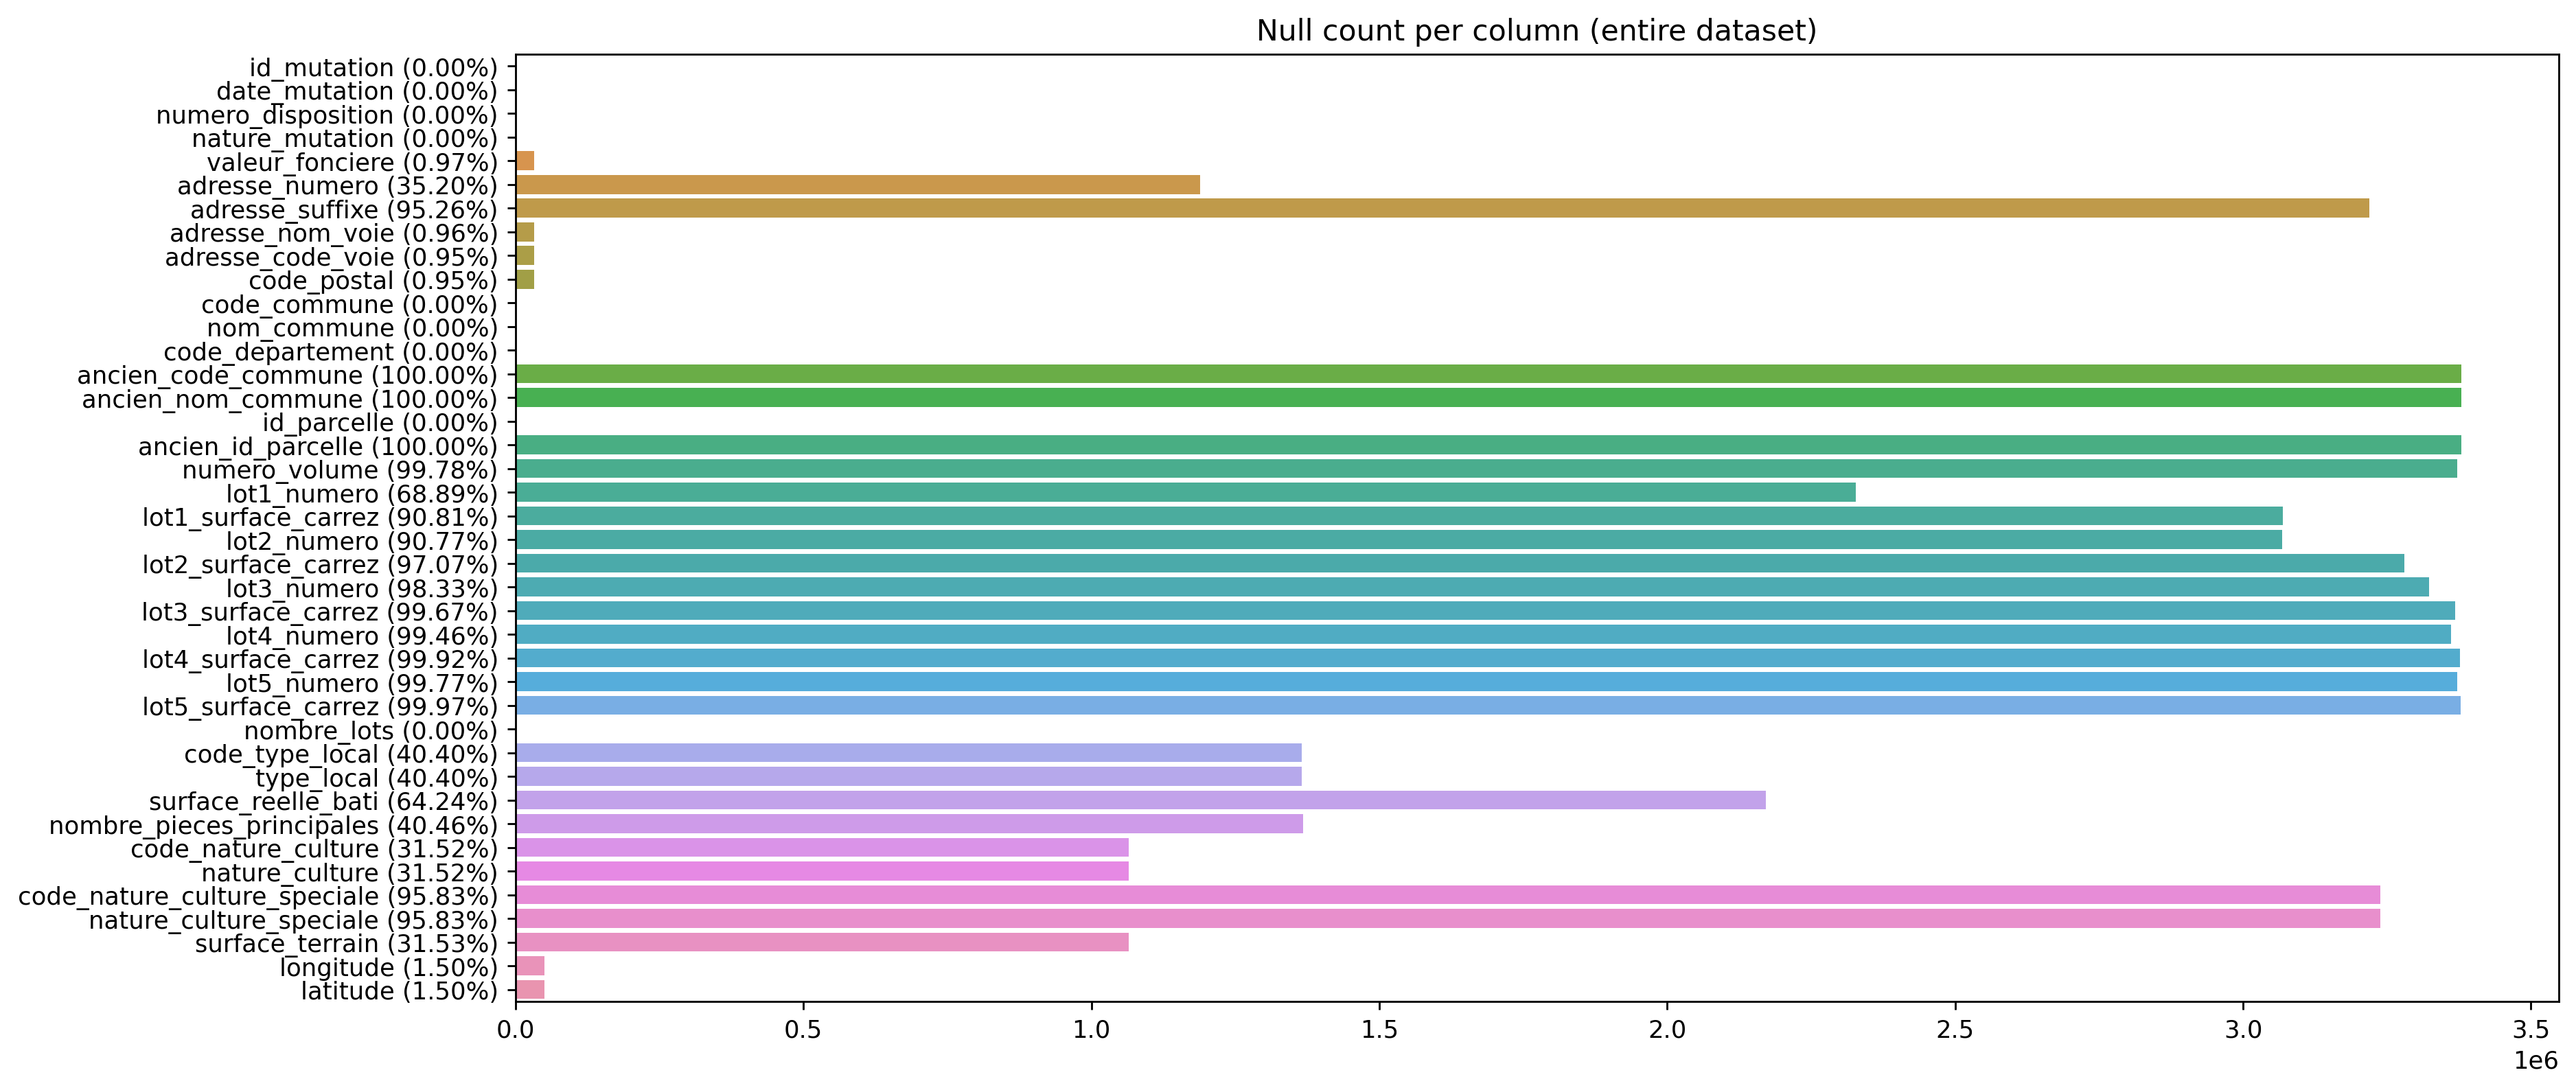

In [ ]:
display_null_cols(df, "Null count per column (entire dataset)")

### Par nature de mutation

In [ ]:
mutation_types = df["nature_mutation"].unique()

for mutation in mutation_types:
    print(f"==== {mutation} ====")
    mutation_df = df[df["nature_mutation"].apply(lambda m: m == mutation)]
    nb_rows = len(mutation_df)
    print(f"\t{nb_rows} rows")
    display_null_cols(mutation_df, f"Null count per column ({mutation}) --> {nb_rows} rows")


Output hidden; open in https://colab.research.google.com to view.

## Fusion des lignes ?

Il y a des lignes qui ont le même id de mutation : est-ce une coïncidence, ou il faut merge les lignes avec le même id ?

In [5]:
print(f"Total count : {len(df)}")
print(f"Total unique mutation : {len(df['id_mutation'].unique())}")

Total count : 3379232
Total unique mutation : 1282421


In [ ]:
groups = df.groupby("id_mutation")
groups.get_group("2021-1")

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,...,type_local,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude
0,2021-1,2021-01-05,1,Vente,185000.0,5080.0,NaN,CHE DE VOGELAS,0471,1370.0,...,Maison,97.0,5.0,S,sols,NaN,NaN,2410.0,5.386094,46.32714
1,2021-1,2021-01-05,1,Vente,185000.0,5080.0,NaN,CHE DE VOGELAS,0471,1370.0,...,Dépendance,NaN,0.0,S,sols,NaN,NaN,2410.0,5.386094,46.32714


In [ ]:
groups.get_group("2021-8")

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,...,type_local,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude
10,2021-8,2021-01-07,1,Vente,4780.0,NaN,NaN,FEUSSAT,B197,1340.0,...,NaN,NaN,NaN,T,terres,NaN,NaN,6114.0,5.161927,46.393824
11,2021-8,2021-01-07,1,Vente,4780.0,NaN,NaN,FEUSSAT,B197,1340.0,...,NaN,NaN,NaN,T,terres,NaN,NaN,6114.0,5.161927,46.393824
12,2021-8,2021-01-07,1,Vente,4780.0,NaN,NaN,BERARDAN,B013,1340.0,...,NaN,NaN,NaN,P,prés,NaN,NaN,7105.0,5.158681,46.387845
13,2021-8,2021-01-07,1,Vente,4780.0,NaN,NaN,LES COMBETTES,B129,1340.0,...,NaN,NaN,NaN,BS,taillis sous futaie,NaN,NaN,4570.0,5.180021,46.386757


Bilan : les entrées multiples sont justes des dépendances, ce qu'on peut vérifier en dégageant tout ce qui a comme type "Dépendance"

In [6]:
no_dependencies = df.drop(df[df["type_local"] == "Dépendance"].index)
no_dependencies = no_dependencies.drop(no_dependencies[no_dependencies["type_local"].isna()].index)
print(len(no_dependencies))
del no_dependencies

1214274


## Nettoyage des lignes trop vides

Ce qui est important parmi les colonnes problématiques : le prix, la surface, le nombre de pièces.

Important aussi, le type de batiment : si NaN, alors y'a pas de batiment (on VEUT un batiment)

In [7]:
useless_columns = [
    "adresse_numero",
    "adresse_suffixe",
    "ancien_code_commune",
    "ancien_nom_commune",
    "ancien_id_parcelle",
    "numero_volume",
    "lot1_numero",
    "lot1_surface_carrez",
    "lot2_numero",
    "lot2_surface_carrez",
    "lot3_numero",
    "lot3_surface_carrez",
    "lot4_numero",
    "lot4_surface_carrez",
    "lot5_numero",
    "lot5_surface_carrez",
    "code_nature_culture",
    "nature_culture",
    "code_nature_culture_speciale",
    "nature_culture_speciale"
]
print(useless_columns)
cleaned_df = df.drop(useless_columns, axis="columns")
cleaned_df


['adresse_numero', 'adresse_suffixe', 'ancien_code_commune', 'ancien_nom_commune', 'ancien_id_parcelle', 'numero_volume', 'lot1_numero', 'lot1_surface_carrez', 'lot2_numero', 'lot2_surface_carrez', 'lot3_numero', 'lot3_surface_carrez', 'lot4_numero', 'lot4_surface_carrez', 'lot5_numero', 'lot5_surface_carrez', 'code_nature_culture', 'nature_culture', 'code_nature_culture_speciale', 'nature_culture_speciale']


,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,id_parcelle,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude
0,2021-1,2021-01-05,1,Vente,185000.0,CHE DE VOGELAS,0471,1370.0,01426,Val-Revermont,01,01426312ZC0122,0,1.0,Maison,97.0,5.0,2410.0,5.386094,46.327140
1,2021-1,2021-01-05,1,Vente,185000.0,CHE DE VOGELAS,0471,1370.0,01426,Val-Revermont,01,01426312ZC0122,0,3.0,Dépendance,NaN,0.0,2410.0,5.386094,46.327140
2,2021-2,2021-01-06,1,Vente,10.0,ROUGEMONT,B043,1290.0,01042,Bey,01,010420000A0204,0,NaN,NaN,NaN,NaN,530.0,4.844402,46.224229
3,2021-3,2021-01-04,1,Vente,204332.0,ALL DES ECUREUILS,0276,1310.0,01065,Buellas,01,010650000B1325,0,1.0,Maison,88.0,4.0,866.0,5.157688,46.200988
4,2021-4,2021-01-06,1,Vente,320000.0,RTE DE CERTINES,0140,1250.0,01254,Montagnat,01,01254000AZ0011,0,1.0,Maison,168.0,5.0,1426.0,5.273260,46.156334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3379227,2021-1282417,2021-03-12,1,Vente,383000.0,RUE DES TOURNELLES,9382,75004.0,75104,Paris 4e Arrondissement,75,75104000AO0117,2,2.0,Appartement,30.0,2.0,NaN,2.367712,48.854200
3379228,2021-1282418,2021-03-17,1,Vente,260000.0,RUE SAINTE FOY,8561,75002.0,75102,Paris 2e Arrondissement,75,75102000AP0128,2,2.0,Appartement,37.0,2.0,NaN,2.350774,48.868450
3379229,2021-1282419,2021-03-19,1,Vente,38000.0,RUE DES GUILLEMITES,4398,75004.0,75104,Paris 4e Arrondissement,75,75104000AH0068,1,3.0,Dépendance,NaN,0.0,NaN,2.357623,48.858041
3379230,2021-1282420,2021-03-30,1,Vente,38000.0,RUE DU PETIT MUSC,7338,75004.0,75104,Paris 4e Arrondissement,75,75104000AP0005,1,3.0,Dépendance,NaN,0.0,NaN,2.365430,48.852861


In [8]:
# All lines with not any value in any of those columns will be deleted
necessary_columns = [
    "date_mutation",
    "nature_mutation",
    "valeur_fonciere",
    "type_local",
    "surface_reelle_bati",
    "nombre_pieces_principales",
    # "surface_terrain" # Can be none if type_local == "Local industriel. commercial ou assimilé" or "Appartement"
]

def are_necessary_colulmns_all_present(row: pd.Series) -> bool:
    return all(pd.notna(row[nc]) for nc in necessary_columns)

cleaned_df = cleaned_df.drop(cleaned_df[~cleaned_df.apply(are_necessary_colulmns_all_present, axis=1)].index)
print(f"Cleaned dataframe length : {len(cleaned_df)}")
cleaned_df

Cleaned dataframe length : 1198439


,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,id_parcelle,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude
0,2021-1,2021-01-05,1,Vente,185000.0,CHE DE VOGELAS,0471,1370.0,01426,Val-Revermont,01,01426312ZC0122,0,1.0,Maison,97.0,5.0,2410.0,5.386094,46.327140
3,2021-3,2021-01-04,1,Vente,204332.0,ALL DES ECUREUILS,0276,1310.0,01065,Buellas,01,010650000B1325,0,1.0,Maison,88.0,4.0,866.0,5.157688,46.200988
4,2021-4,2021-01-06,1,Vente,320000.0,RTE DE CERTINES,0140,1250.0,01254,Montagnat,01,01254000AZ0011,0,1.0,Maison,168.0,5.0,1426.0,5.273260,46.156334
7,2021-6,2021-01-04,1,Vente,176000.0,RUE GEORGE SAND,0820,1000.0,01344,Saint-Denis-lès-Bourg,01,01344000AC0181,1,2.0,Appartement,71.0,3.0,NaN,5.200117,46.210292
14,2021-9,2021-01-04,2,Vente,226700.0,CHE DU MOULIN DE POLAIZE,0164,1310.0,01301,Polliat,01,01301000AA0289,0,1.0,Maison,96.0,3.0,NaN,5.108604,46.244066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3379225,2021-1282416,2021-03-04,1,Vente,400000.0,RUE DE JARENTE,4831,75004.0,75104,Paris 4e Arrondissement,75,75104000AN0041,1,2.0,Appartement,26.0,1.0,NaN,2.363350,48.855926
3379226,2021-1282416,2021-03-04,1,Vente,400000.0,RUE DE JARENTE,4831,75004.0,75104,Paris 4e Arrondissement,75,75104000AN0041,1,2.0,Appartement,25.0,1.0,NaN,2.363350,48.855926
3379227,2021-1282417,2021-03-12,1,Vente,383000.0,RUE DES TOURNELLES,9382,75004.0,75104,Paris 4e Arrondissement,75,75104000AO0117,2,2.0,Appartement,30.0,2.0,NaN,2.367712,48.854200
3379228,2021-1282418,2021-03-17,1,Vente,260000.0,RUE SAINTE FOY,8561,75002.0,75102,Paris 2e Arrondissement,75,75102000AP0128,2,2.0,Appartement,37.0,2.0,NaN,2.350774,48.868450


Avec ces changements, on a encore des lignes qui ont les mêmes id_mutation ?

In [9]:
print(f"Nb rows : {len(cleaned_df)}")
print(f"Nb rows with unique id_mutation : {len(cleaned_df['id_mutation'].unique())}")

Nb rows : 1198439
Nb rows with unique id_mutation : 902836


Oui...

2ème question : ces lignes sont-elles identiques tout le temps ?

In [ ]:
# Calcul long , on évite de le refaire
%%script echo skipping
from tqdm import tqdm
def are_rows_identical(df: pd.DataFrame) -> bool:
    for col in df.columns:
        vals = df[col].values
        if (vals[0] != vals).any():
            return False
    return True

non_identical_muts = [id_mutation 
    for id_mutation, group in tqdm(cleaned_df.groupby("id_mutation"))
    if not are_rows_identical(group)
]

In [ ]:
print(non_identical_muts)

Output hidden; open in https://colab.research.google.com to view.

Il y a beaucoup de lignes avec même id de mutation mais des lignes non identiques.

Voyons des exemples pour comprendre.

In [ ]:
print(cleaned_df[cleaned_df["id_mutation"] == "2021-100"].iloc[0])
print("==========")
print(cleaned_df[cleaned_df["id_mutation"] == "2021-100"].iloc[1])

id_mutation                                   2021-100
date_mutation                               2021-01-11
numero_disposition                                   1
nature_mutation                                  Vente
valeur_fonciere                               140000.0
adresse_nom_voie             RTE DE LA VIEILLERE HAUTE
adresse_code_voie                                 0225
code_postal                                     1270.0
code_commune                                     01029
nom_commune                                   Beaupont
code_departement                                    01
id_parcelle                             01029000ZH0085
nombre_lots                                          0
code_type_local                                    1.0
type_local                                      Maison
surface_reelle_bati                              116.0
nombre_pieces_principales                          3.0
surface_terrain                                 1424.0
longitude 

In [ ]:
print(cleaned_df[cleaned_df["id_mutation"] == "2021-1000035"].iloc[0])
print("==========")
print(cleaned_df[cleaned_df["id_mutation"] == "2021-1000035"].iloc[1])

id_mutation                    2021-1000035
date_mutation                    2021-11-05
numero_disposition                        2
nature_mutation                       Vente
valeur_fonciere                    133200.0
adresse_nom_voie              RUE DU MAQUIS
adresse_code_voie                      4936
code_postal                         82000.0
code_commune                          82121
nom_commune                       Montauban
code_departement                         82
id_parcelle                  82121000AW0586
nombre_lots                               0
code_type_local                         2.0
type_local                      Appartement
surface_reelle_bati                    65.0
nombre_pieces_principales               3.0
surface_terrain                       648.0
longitude                          1.371762
latitude                          44.014909
date_mutation_annee                    2021
date_mutation_mois                       11
date_mutation_jour              

Bilan : Il s'agit d'un changement de valeur, mais aucun moyen de savoir lequel est le bon (à moins de faire du cas par cas, ce qui est fortement impossible).

En regardant sur google maps, on peut voir que :

* "2021-100": le jardin est plutot grand, donc le terrain semble plus 
proche des 3000 que des 1000
* "2021-1000035": il s'agit d'une maison, pas de débat

Donc, pour chacune des observations (que 2 gardées pour éviter de prendre trop de place), la dernière entrée est la plus valide. 

Pour chaque groupe avec un doublon d'id mutation, on garde la dernière ligne.

In [11]:
from tqdm import tqdm
from typing import Iterable

columns = cleaned_df.columns.tolist()

def gen_no_duplicates(dataframe: pd.DataFrame, col: str) -> Iterable[pd.Series]:
    return (group.iloc[-1] for _, group in tqdm(dataframe.groupby(col)))

cleaned_df = pd.DataFrame(gen_no_duplicates(cleaned_df, "id_mutation"), columns=columns)
cleaned_df

100%|██████████| 902836/902836 [02:45<00:00, 5454.64it/s]


,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,id_parcelle,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude
0,2021-1,2021-01-05,1,Vente,185000.0,CHE DE VOGELAS,0471,1370.0,01426,Val-Revermont,01,01426312ZC0122,0,1.0,Maison,97.0,5.0,2410.0,5.386094,46.327140
15,2021-10,2021-01-08,1,Vente,185000.0,RUE DES GRANGES BONNET,0161,1960.0,01289,Péronnas,01,01289000AD0031,0,1.0,Maison,100.0,4.0,703.0,5.210226,46.187698
278,2021-100,2021-01-11,1,Vente,140000.0,RTE DE LA VIEILLERE HAUTE,0225,1270.0,01029,Beaupont,01,01029000ZH0085,0,1.0,Maison,116.0,3.0,3022.0,5.264282,46.422929
3202,2021-1000,2021-04-01,1,Vente,72150.0,RUE HENRI DUNANT,1860,1000.0,01053,Bourg-en-Bresse,01,01053000BM0109,2,2.0,Appartement,86.0,4.0,NaN,5.228771,46.213260
29486,2021-10000,2021-04-30,1,Vente,137000.0,AUX CREUSES,B009,1090.0,01169,Genouilleux,01,011690000B0423,1,1.0,Maison,70.0,2.0,NaN,4.794552,46.124586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2709217,2021-999991,2021-10-26,1,Vente,125000.0,CHE DU QUART,6712,82000.0,82121,Montauban,82,82121000HR0603,0,2.0,Appartement,60.0,3.0,693.0,1.321546,43.985077
2709221,2021-999992,2021-10-25,3,Vente,1.0,RTE DE L'AVEYRON,0333,82000.0,82121,Montauban,82,82121000CO0901,0,1.0,Maison,128.0,5.0,231.0,1.336899,44.057871
2709227,2021-999994,2021-10-15,1,Vente,295000.0,CHE GIBERTOU,0080,82390.0,82051,Durfort-Lacapelette,82,82051000AX0249,0,1.0,Maison,308.0,7.0,848.0,1.140591,44.169150
2709233,2021-999995,2021-10-27,1,Vente,225000.0,CHE DES DAMES NOIRES,2431,82000.0,82121,Montauban,82,82121000EY0101,0,1.0,Maison,120.0,5.0,2098.0,1.366484,43.989597


## Ajustement de la donnée
On modifie certaines valeurs pour être plus utilisables question visualisation

Pour les "appartements" et "Local industriel. commercial ou assimilé",
la surface du terrain est à "NaN" (évidemment) : il faut la repasser à 0

In [12]:
cleaned_df.loc[cleaned_df["surface_terrain"].isna(), "surface_terrain"] = 0.0
cleaned_df

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,id_parcelle,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude
0,2021-1,2021-01-05,1,Vente,185000.0,CHE DE VOGELAS,0471,1370.0,01426,Val-Revermont,01,01426312ZC0122,0,1.0,Maison,97.0,5.0,2410.0,5.386094,46.327140
15,2021-10,2021-01-08,1,Vente,185000.0,RUE DES GRANGES BONNET,0161,1960.0,01289,Péronnas,01,01289000AD0031,0,1.0,Maison,100.0,4.0,703.0,5.210226,46.187698
278,2021-100,2021-01-11,1,Vente,140000.0,RTE DE LA VIEILLERE HAUTE,0225,1270.0,01029,Beaupont,01,01029000ZH0085,0,1.0,Maison,116.0,3.0,3022.0,5.264282,46.422929
3202,2021-1000,2021-04-01,1,Vente,72150.0,RUE HENRI DUNANT,1860,1000.0,01053,Bourg-en-Bresse,01,01053000BM0109,2,2.0,Appartement,86.0,4.0,0.0,5.228771,46.213260
29486,2021-10000,2021-04-30,1,Vente,137000.0,AUX CREUSES,B009,1090.0,01169,Genouilleux,01,011690000B0423,1,1.0,Maison,70.0,2.0,0.0,4.794552,46.124586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2709217,2021-999991,2021-10-26,1,Vente,125000.0,CHE DU QUART,6712,82000.0,82121,Montauban,82,82121000HR0603,0,2.0,Appartement,60.0,3.0,693.0,1.321546,43.985077
2709221,2021-999992,2021-10-25,3,Vente,1.0,RTE DE L'AVEYRON,0333,82000.0,82121,Montauban,82,82121000CO0901,0,1.0,Maison,128.0,5.0,231.0,1.336899,44.057871
2709227,2021-999994,2021-10-15,1,Vente,295000.0,CHE GIBERTOU,0080,82390.0,82051,Durfort-Lacapelette,82,82051000AX0249,0,1.0,Maison,308.0,7.0,848.0,1.140591,44.169150
2709233,2021-999995,2021-10-27,1,Vente,225000.0,CHE DES DAMES NOIRES,2431,82000.0,82121,Montauban,82,82121000EY0101,0,1.0,Maison,120.0,5.0,2098.0,1.366484,43.989597


On veut séparer la date en année, mois, jour : on peut éventuellement voir une tendance au cours des mois d'une année.

In [13]:
# We can assign multiple columns with one mapping directly
cleaned_df[["date_mutation_annee", "date_mutation_mois", "date_mutation_jour"]] = (
    cleaned_df["date_mutation"].str.split("-", 0, expand=True)
)
cleaned_df

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,...,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude,date_mutation_annee,date_mutation_mois,date_mutation_jour
0,2021-1,2021-01-05,1,Vente,185000.0,CHE DE VOGELAS,0471,1370.0,01426,Val-Revermont,...,1.0,Maison,97.0,5.0,2410.0,5.386094,46.327140,2021,01,05
15,2021-10,2021-01-08,1,Vente,185000.0,RUE DES GRANGES BONNET,0161,1960.0,01289,Péronnas,...,1.0,Maison,100.0,4.0,703.0,5.210226,46.187698,2021,01,08
278,2021-100,2021-01-11,1,Vente,140000.0,RTE DE LA VIEILLERE HAUTE,0225,1270.0,01029,Beaupont,...,1.0,Maison,116.0,3.0,3022.0,5.264282,46.422929,2021,01,11
3202,2021-1000,2021-04-01,1,Vente,72150.0,RUE HENRI DUNANT,1860,1000.0,01053,Bourg-en-Bresse,...,2.0,Appartement,86.0,4.0,0.0,5.228771,46.213260,2021,04,01
29486,2021-10000,2021-04-30,1,Vente,137000.0,AUX CREUSES,B009,1090.0,01169,Genouilleux,...,1.0,Maison,70.0,2.0,0.0,4.794552,46.124586,2021,04,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2709217,2021-999991,2021-10-26,1,Vente,125000.0,CHE DU QUART,6712,82000.0,82121,Montauban,...,2.0,Appartement,60.0,3.0,693.0,1.321546,43.985077,2021,10,26
2709221,2021-999992,2021-10-25,3,Vente,1.0,RTE DE L'AVEYRON,0333,82000.0,82121,Montauban,...,1.0,Maison,128.0,5.0,231.0,1.336899,44.057871,2021,10,25
2709227,2021-999994,2021-10-15,1,Vente,295000.0,CHE GIBERTOU,0080,82390.0,82051,Durfort-Lacapelette,...,1.0,Maison,308.0,7.0,848.0,1.140591,44.169150,2021,10,15
2709233,2021-999995,2021-10-27,1,Vente,225000.0,CHE DES DAMES NOIRES,2431,82000.0,82121,Montauban,...,1.0,Maison,120.0,5.0,2098.0,1.366484,43.989597,2021,10,27


## Visualisation globale

On veut voir la répartition des données par plusieurs types

### Valeur foncière par...

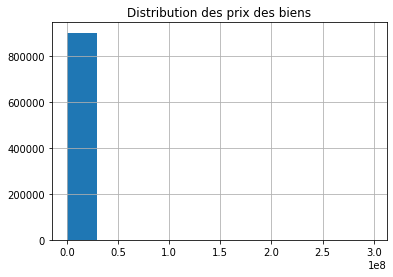

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.title("Distribution des prix des biens")
cleaned_df["valeur_fonciere"].hist()
plt.show()

On peut voir qu'on a une petite partie des valeurs qui sont bien plus hautes que les autres (au dessus de 200 000 000€ ?!!)

In [16]:
really_expensive_df = cleaned_df[cleaned_df["valeur_fonciere"] > 10_000_000]
print(f"Number of really expensive (above 10 000 000) : {len(really_expensive_df)}")
really_expensive_df

Number of really expensive (above 10 000 000) : 548


,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,...,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude,date_mutation_annee,date_mutation_mois,date_mutation_jour
2713736,2021-1001749,2021-04-06,1,Vente,25912404.0,PARCS DE SAINT TROPEZ,B062,83990.0,83119,Saint-Tropez,...,1.0,Maison,530.0,13.0,500.0,6.679172,43.277194,2021,04,06
2714532,2021-1002078,2021-05-25,1,Vente,14268000.0,AV DU BELVEDERE,0020,83350.0,83101,Ramatuelle,...,1.0,Maison,220.0,7.0,2235.0,6.657236,43.226679,2021,05,25
2715442,2021-1002388,2021-07-09,1,Vente,33000000.0,PARCS DE SAINT TROPEZ,B062,83990.0,83119,Saint-Tropez,...,1.0,Maison,530.0,13.0,500.0,6.679172,43.277194,2021,07,09
2735624,2021-1011812,2021-06-24,1,Vente,10770000.0,SAINT MICHEL,B096,83130.0,83062,La Garde,...,4.0,Local industriel. commercial ou assimilé,571.0,0.0,1000.0,6.019582,43.138429,2021,06,24
2767209,2021-1025294,2021-12-17,1,Vente,13025000.0,AV MARECHAL LECLERC,0311,84130.0,84092,Le Pontet,...,4.0,Local industriel. commercial ou assimilé,4313.0,0.0,13693.0,4.866310,43.972588,2021,12,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2608207,2021-962928,2021-09-30,1,Vente,19700000.0,ESP DU GD SIECLE,0952,78000.0,78646,Versailles,...,4.0,Local industriel. commercial ou assimilé,5814.0,0.0,0.0,2.158672,48.804100,2021,09,30
2610407,2021-963790,2021-11-23,1,Vente,11500000.0,RUE DE TEMARA,2168,78100.0,78551,Saint-Germain-en-Laye,...,4.0,Local industriel. commercial ou assimilé,1468.0,0.0,2055.0,2.074218,48.893091,2021,11,23
2619557,2021-968225,2021-03-10,1,Vente,10940000.0,RUE RENE CAUDRON,0414,78960.0,78688,Voisins-le-Bretonneux,...,4.0,Local industriel. commercial ou assimilé,3724.0,0.0,6084.0,2.061887,48.759281,2021,03,10
2621831,2021-969149,2021-01-29,1,Vente,18333210.0,AV DE LIMOGES,3190,79000.0,79191,Niort,...,4.0,Local industriel. commercial ou assimilé,1115.0,0.0,6795.0,-0.412642,46.317115,2021,01,29


Il y a des villes qui ne devraient pas avoir ce genre de valeurs : voyons la distribution de valeur pour chaque ville ayant des biens super chers

In [17]:
# Abergement-la-Ronce ???
really_expensive_df["nom_commune"].unique()
expensive_groups = really_expensive_df.groupby("nom_commune")

print("==== Really expensive cities ====")
for name, group in expensive_groups:
    # group.iterrows() iteration give tuple(index, row)
    vf = group["valeur_fonciere"]
    print(f"{name} ({len(group)})\n\t min={int(vf.min())}, mean={int(vf.mean())} max={int(vf.max())}")

print("==== Have same min, mean and max values ? ====")
n_no, n_yes = [], []
for name, group in expensive_groups:
    # group.iterrows() iteration give tuple(index, row)
    vf = group["valeur_fonciere"]
    if vf.min() == vf.mean() == vf.max() and len(group) > 1: n_yes.append(name)
    else: n_no.append(name)

print(f"\t No : {n_no}")
print(f"\t Yes : {n_yes}")


==== Really expensive cities ====
Ablon-sur-Seine (1)
	 min=20850036, mean=20850036 max=20850036
Aix-en-Provence (1)
	 min=19000000, mean=19000000 max=19000000
Alfortville (3)
	 min=22300000, mean=37079333 max=55500000
Alès (1)
	 min=12634407, mean=12634407 max=12634407
Amfreville-la-Mi-Voie (1)
	 min=36855776, mean=36855776 max=36855776
Antibes (2)
	 min=10520000, mean=12760000 max=15000000
Anzin (3)
	 min=10500000, mean=17763333 max=25270000
Arcueil (2)
	 min=16835000, mean=157317500 max=297800000
Argenteuil (1)
	 min=11500000, mean=11500000 max=11500000
Aubervilliers (2)
	 min=12600000, mean=13800000 max=15000000
Audenge (1)
	 min=10160000, mean=10160000 max=10160000
Aulnay-sous-Bois (1)
	 min=42379956, mean=42379956 max=42379956
Aurillac (1)
	 min=26597376, mean=26597376 max=26597376
Auxerre (2)
	 min=21094000, mean=22311416 max=23528832
Bagneux (1)
	 min=21150000, mean=21150000 max=21150000
Bayeux (2)
	 min=12000000, mean=12126671 max=12253342
Beaulieu-sur-Mer (1)
	 min=10500000, 

Bilan : on va enlever les lignes ou le prix dépasse 50 millions d'euros. On aura une bien moins mauvaise répartition de la donnée comme ça.

In [18]:
cleaned_df = cleaned_df[cleaned_df["valeur_fonciere"] <= 10_000_000]
print("Max price :", cleaned_df["valeur_fonciere"].max())
cleaned_df

Max price : 10000000.0


,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,...,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude,date_mutation_annee,date_mutation_mois,date_mutation_jour
0,2021-1,2021-01-05,1,Vente,185000.0,CHE DE VOGELAS,0471,1370.0,01426,Val-Revermont,...,1.0,Maison,97.0,5.0,2410.0,5.386094,46.327140,2021,01,05
15,2021-10,2021-01-08,1,Vente,185000.0,RUE DES GRANGES BONNET,0161,1960.0,01289,Péronnas,...,1.0,Maison,100.0,4.0,703.0,5.210226,46.187698,2021,01,08
278,2021-100,2021-01-11,1,Vente,140000.0,RTE DE LA VIEILLERE HAUTE,0225,1270.0,01029,Beaupont,...,1.0,Maison,116.0,3.0,3022.0,5.264282,46.422929,2021,01,11
3202,2021-1000,2021-04-01,1,Vente,72150.0,RUE HENRI DUNANT,1860,1000.0,01053,Bourg-en-Bresse,...,2.0,Appartement,86.0,4.0,0.0,5.228771,46.213260,2021,04,01
29486,2021-10000,2021-04-30,1,Vente,137000.0,AUX CREUSES,B009,1090.0,01169,Genouilleux,...,1.0,Maison,70.0,2.0,0.0,4.794552,46.124586,2021,04,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2709217,2021-999991,2021-10-26,1,Vente,125000.0,CHE DU QUART,6712,82000.0,82121,Montauban,...,2.0,Appartement,60.0,3.0,693.0,1.321546,43.985077,2021,10,26
2709221,2021-999992,2021-10-25,3,Vente,1.0,RTE DE L'AVEYRON,0333,82000.0,82121,Montauban,...,1.0,Maison,128.0,5.0,231.0,1.336899,44.057871,2021,10,25
2709227,2021-999994,2021-10-15,1,Vente,295000.0,CHE GIBERTOU,0080,82390.0,82051,Durfort-Lacapelette,...,1.0,Maison,308.0,7.0,848.0,1.140591,44.169150,2021,10,15
2709233,2021-999995,2021-10-27,1,Vente,225000.0,CHE DES DAMES NOIRES,2431,82000.0,82121,Montauban,...,1.0,Maison,120.0,5.0,2098.0,1.366484,43.989597,2021,10,27


#### Par date (entière, puis par jour, mois)

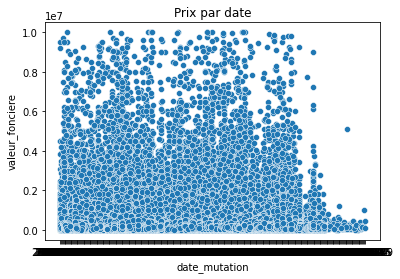

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.title("Prix par date")
sns.scatterplot(data=cleaned_df[["date_mutation", "valeur_fonciere"]], x="date_mutation", y="valeur_fonciere")
plt.show()

Par date entière, c'est pas super utile. Normalement la spéraration par mois devrait donner quelque chose de plus intéressant

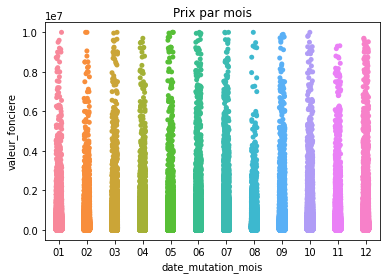

In [20]:
plt.title("Prix par mois")
sns.stripplot(data=cleaned_df[["date_mutation_mois", "valeur_fonciere"]], x="date_mutation_mois", y="valeur_fonciere", order=(f"{n:02d}" for n in range(1, 13)))
plt.show()

# TODO : prix median par mois (ou quartile, etc)

In [32]:
# Save the actual dataframe
# Before saving it, we want to set the columns properly
dataset = cleaned_df.copy()
dataset["valeur_fonciere"] = dataset["valeur_fonciere"].astype(int)
# Not all rows have a postal code, but they do have a city code (INSEE)
dataset["code_postal"] = dataset["code_postal"].apply(lambda c: f"{int(c):05d}" if pd.notna(c) else "00000")
dataset["code_type_local"] = dataset["code_type_local"].astype(int)
dataset["nombre_pieces_principales"] = dataset["nombre_pieces_principales"].astype(int)
dataset

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,...,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude,date_mutation_annee,date_mutation_mois,date_mutation_jour
0,2021-1,2021-01-05,1,Vente,185000,CHE DE VOGELAS,0471,01370,01426,Val-Revermont,...,1,Maison,97.0,5,2410.0,5.386094,46.327140,2021,01,05
15,2021-10,2021-01-08,1,Vente,185000,RUE DES GRANGES BONNET,0161,01960,01289,Péronnas,...,1,Maison,100.0,4,703.0,5.210226,46.187698,2021,01,08
278,2021-100,2021-01-11,1,Vente,140000,RTE DE LA VIEILLERE HAUTE,0225,01270,01029,Beaupont,...,1,Maison,116.0,3,3022.0,5.264282,46.422929,2021,01,11
3202,2021-1000,2021-04-01,1,Vente,72150,RUE HENRI DUNANT,1860,01000,01053,Bourg-en-Bresse,...,2,Appartement,86.0,4,0.0,5.228771,46.213260,2021,04,01
29486,2021-10000,2021-04-30,1,Vente,137000,AUX CREUSES,B009,01090,01169,Genouilleux,...,1,Maison,70.0,2,0.0,4.794552,46.124586,2021,04,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2709217,2021-999991,2021-10-26,1,Vente,125000,CHE DU QUART,6712,82000,82121,Montauban,...,2,Appartement,60.0,3,693.0,1.321546,43.985077,2021,10,26
2709221,2021-999992,2021-10-25,3,Vente,1,RTE DE L'AVEYRON,0333,82000,82121,Montauban,...,1,Maison,128.0,5,231.0,1.336899,44.057871,2021,10,25
2709227,2021-999994,2021-10-15,1,Vente,295000,CHE GIBERTOU,0080,82390,82051,Durfort-Lacapelette,...,1,Maison,308.0,7,848.0,1.140591,44.169150,2021,10,15
2709233,2021-999995,2021-10-27,1,Vente,225000,CHE DES DAMES NOIRES,2431,82000,82121,Montauban,...,1,Maison,120.0,5,2098.0,1.366484,43.989597,2021,10,27


In [33]:
DATASET_OUT_PATH = Path("./dataset_2021.csv")
dataset.to_csv(DATASET_OUT_PATH.as_posix())